##### This is a fork of [best-public-score](https://www.kaggle.com/code/peizhengwang/best-public-score) notebook with some tuned hyperparameters for LightGBM model, that result in a slight improvement of LB score: 5.3365 -> 5.3359. All the credits go to the original author @peizhengwang.

In [1]:
import gc  
import os  
import time  
import warnings 
from itertools import combinations  
from warnings import simplefilter 
import joblib  
import lightgbm as lgb  
import numpy as np  
import pandas as pd  
from sklearn.metrics import mean_absolute_error 
from sklearn.model_selection import KFold, TimeSeriesSplit 
import matplotlib.pyplot as plt

import polars as pl
warnings.filterwarnings("ignore")
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

is_offline = False 
LGB = True
NN = False
is_train = True
is_test = False # true for n_est=1 & cpu training
is_infer = True # to submit or not
max_lookback = np.nan 
split_day = 435  

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


# **Utilities**

In [2]:
def weighted_average(a):
    w = []
    n = len(a)
    for j in range(1, n + 1):
        j = 2 if j == 1 else j
        w.append(1 / (2**(n + 1 - j)))
    return w

In [3]:
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# modified code for group gaps; source
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size
 
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]
            
            
            if self.verbose > 0:
                    pass
                    
            yield [int(i) for i in train_array], [int(i) for i in test_array]

In [4]:
def reduce_mem_usage(df, verbose=0):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
               
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)
    if verbose:
        logger.info(f"Memory usage of dataframe is {start_mem:.2f} MB")
        end_mem = df.memory_usage().sum() / 1024**2
        logger.info(f"Memory usage after optimization is: {end_mem:.2f} MB")
        decrease = 100 * (start_mem - end_mem) / start_mem
        logger.info(f"Decreased by {decrease:.2f}%")
    return df


# Data Loading






In [5]:
df = pd.read_csv("/kaggle/input/optiver-trading-at-the-close/train.csv")
df = df.dropna(subset=["target"])
df.reset_index(drop=True, inplace=True)
df_shape = df.shape

df_test = pd.read_csv('../input/optiver-trading-at-the-close/example_test_files/test.csv')
rev_target = pd.read_csv('../input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv')

rev_target = rev_target.dropna(subset=['stock_id'])
y_test = rev_target[['seconds_in_bucket', 'revealed_target']]

 # Parallel Triplet Imbalance Calculation

In [6]:
from numba import njit, prange

@njit(parallel=True)
def compute_triplet_imbalance(df_values, comb_indices):
    num_rows = df_values.shape[0]
    num_combinations = len(comb_indices)
    imbalance_features = np.empty((num_rows, num_combinations))
    for i in prange(num_combinations):
        a, b, c = comb_indices[i]
        for j in range(num_rows):
            max_val = max(df_values[j, a], df_values[j, b], df_values[j, c])
            min_val = min(df_values[j, a], df_values[j, b], df_values[j, c])
            mid_val = df_values[j, a] + df_values[j, b] + df_values[j, c] - min_val - max_val
            
            if mid_val == min_val:
                imbalance_features[j, i] = np.nan
            else:
                imbalance_features[j, i] = (max_val - mid_val) / (mid_val - min_val)

    return imbalance_features

def calculate_triplet_imbalance_numba(price, df):
    df_values = df[price].values
    comb_indices = [(price.index(a), price.index(b), price.index(c)) for a, b, c in combinations(price, 3)]
    features_array = compute_triplet_imbalance(df_values, comb_indices)
    columns = [f"{a}_{b}_{c}_imb2" for a, b, c in combinations(price, 3)]
    features = pd.DataFrame(features_array, columns=columns)
    return features


# Feature Generation Functions 

In [7]:
def imbalance_features(df):
    # Define lists of price and size-related column names
    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]
    
    df["volume"] = df.eval("ask_size + bid_size")
    df["mid_price"] = df.eval("(ask_price + bid_price) / 2")
    df["liquidity_imbalance"] = df.eval("(bid_size-ask_size)/(bid_size+ask_size)")
    df["matched_imbalance"] = df.eval("(imbalance_size-matched_size)/(matched_size+imbalance_size)")
    df["size_imbalance"] = df.eval("bid_size / ask_size")

    for c in combinations(prices, 2):
        df[f"{c[0]}_{c[1]}_imb"] = df.eval(f"({c[0]} - {c[1]})/({c[0]} + {c[1]})")

    for c in [['ask_price', 'bid_price', 'wap', 'reference_price'], sizes]:
        triplet_feature = calculate_triplet_imbalance_numba(c, df)
        df[triplet_feature.columns] = triplet_feature.values
    
    df["stock_weights"] = df["stock_id"].map(weights)
    df["weighted_wap"] = df["stock_weights"] * df["wap"]
    df['wap_momentum'] = df.groupby('stock_id')['weighted_wap'].pct_change(periods=6)
   
    df["imbalance_momentum"] = df.groupby(['stock_id'])['imbalance_size'].diff(periods=1) / df['matched_size']
    df["price_spread"] = df["ask_price"] - df["bid_price"]
    df["spread_intensity"] = df.groupby(['stock_id'])['price_spread'].diff()
    df['price_pressure'] = df['imbalance_size'] * (df['ask_price'] - df['bid_price'])
    df['market_urgency'] = df['price_spread'] * df['liquidity_imbalance']
    df['depth_pressure'] = (df['ask_size'] - df['bid_size']) * (df['far_price'] - df['near_price'])
    
    df['spread_depth_ratio'] = (df['ask_price'] - df['bid_price']) / (df['bid_size'] + df['ask_size'])
    df['mid_price_movement'] = df['mid_price'].diff(periods=5).apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    
    df['micro_price'] = ((df['bid_price'] * df['ask_size']) + (df['ask_price'] * df['bid_size'])) / (df['bid_size'] + df['ask_size'])
    df['relative_spread'] = (df['ask_price'] - df['bid_price']) / df['wap']
    
    # Calculate various statistical aggregation features
    for func in ["mean", "std", "skew", "kurt"]:
        df[f"all_prices_{func}"] = df[prices].agg(func, axis=1)
        df[f"all_sizes_{func}"] = df[sizes].agg(func, axis=1)
        

    for col in ['matched_size', 'imbalance_size', 'reference_price', 'imbalance_buy_sell_flag']:
        for window in [1,3,5,10]:
            df[f"{col}_shift_{window}"] = df.groupby('stock_id')[col].shift(window)
            df[f"{col}_ret_{window}"] = df.groupby('stock_id')[col].pct_change(window)
    
    # Calculate diff features for specific columns
    for col in ['ask_price', 'bid_price', 'ask_size', 'bid_size', 'weighted_wap','price_spread']:
        for window in [1,3,5,10]:
            df[f"{col}_diff_{window}"] = df.groupby("stock_id")[col].diff(window)
    
    #V4 feature
    for window in [3,5,10]:
        df[f'price_change_diff_{window}'] = df[f'bid_price_diff_{window}'] - df[f'ask_price_diff_{window}']
        df[f'size_change_diff_{window}'] = df[f'bid_size_diff_{window}'] - df[f'ask_size_diff_{window}']

    #V5 - rolling diff
    # Convert from pandas to Polars
    pl_df = pl.from_pandas(df)

    #Define the windows and columns for which you want to calculate the rolling statistics
    windows = [3, 5, 10]
    columns = ['ask_price', 'bid_price', 'ask_size', 'bid_size']

    # prepare the operations for each column and window
    group = ["stock_id"]
    expressions = []

    # Loop over each window and column to create the rolling mean and std expressions
    for window in windows:
        for col in columns:
            rolling_mean_expr = (
                pl.col(f"{col}_diff_{window}")
                .rolling_mean(window)
                .over(group)
                .alias(f'rolling_diff_{col}_{window}')
            )

            rolling_std_expr = (
                pl.col(f"{col}_diff_{window}")
                .rolling_std(window)
                .over(group)
                .alias(f'rolling_std_diff_{col}_{window}')
            )

            expressions.append(rolling_mean_expr)
            expressions.append(rolling_std_expr)

    # Run the operations using Polars' lazy API
    lazy_df = pl_df.lazy().with_columns(expressions)

    # Execute the lazy expressions and overwrite the pl_df variable
    pl_df = lazy_df.collect()

    # Convert back to pandas if necessary
    df = pl_df.to_pandas()
    gc.collect()
    
    df['mid_price*volume'] = df['mid_price_movement'] * df['volume']
    df['harmonic_imbalance'] = df.eval('2 / ((1 / bid_size) + (1 / ask_size))')
    
    for col in df.columns:
        df[col] = df[col].replace([np.inf, -np.inf], 0)

    return df

def other_features(df):
    df["dow"] = df["date_id"] % 5  # Day of the week
    df["seconds"] = df["seconds_in_bucket"] % 60  
    df["minute"] = df["seconds_in_bucket"] // 60  
    df['time_to_market_close'] = 540 - df['seconds_in_bucket']
    
    for key, value in global_stock_id_feats.items():
        df[f"global_{key}"] = df["stock_id"].map(value.to_dict())

    return df

def generate_all_features(df):
    # Select relevant columns for feature generation
    cols = [c for c in df.columns if c not in ["row_id", "time_id", "target"]]
    df = df[cols]
    
    # Generate imbalance features
    df = imbalance_features(df)
    gc.collect() 
    df = other_features(df)
    gc.collect()  
    feature_name = [i for i in df.columns if i not in ["row_id", "target", "time_id", "date_id"]]
    
    return df[feature_name]


In [8]:
weights = [
    0.004, 0.001, 0.002, 0.006, 0.004, 0.004, 0.002, 0.006, 0.006, 0.002, 0.002, 0.008,
    0.006, 0.002, 0.008, 0.006, 0.002, 0.006, 0.004, 0.002, 0.004, 0.001, 0.006, 0.004,
    0.002, 0.002, 0.004, 0.002, 0.004, 0.004, 0.001, 0.001, 0.002, 0.002, 0.006, 0.004,
    0.004, 0.004, 0.006, 0.002, 0.002, 0.04 , 0.002, 0.002, 0.004, 0.04 , 0.002, 0.001,
    0.006, 0.004, 0.004, 0.006, 0.001, 0.004, 0.004, 0.002, 0.006, 0.004, 0.006, 0.004,
    0.006, 0.004, 0.002, 0.001, 0.002, 0.004, 0.002, 0.008, 0.004, 0.004, 0.002, 0.004,
    0.006, 0.002, 0.004, 0.004, 0.002, 0.004, 0.004, 0.004, 0.001, 0.002, 0.002, 0.008,
    0.02 , 0.004, 0.006, 0.002, 0.02 , 0.002, 0.002, 0.006, 0.004, 0.002, 0.001, 0.02,
    0.006, 0.001, 0.002, 0.004, 0.001, 0.002, 0.006, 0.006, 0.004, 0.006, 0.001, 0.002,
    0.004, 0.006, 0.006, 0.001, 0.04 , 0.006, 0.002, 0.004, 0.002, 0.002, 0.006, 0.002,
    0.002, 0.004, 0.006, 0.006, 0.002, 0.002, 0.008, 0.006, 0.004, 0.002, 0.006, 0.002,
    0.004, 0.006, 0.002, 0.004, 0.001, 0.004, 0.002, 0.004, 0.008, 0.006, 0.008, 0.002,
    0.004, 0.002, 0.001, 0.004, 0.004, 0.004, 0.006, 0.008, 0.004, 0.001, 0.001, 0.002,
    0.006, 0.004, 0.001, 0.002, 0.006, 0.004, 0.006, 0.008, 0.002, 0.002, 0.004, 0.002,
    0.04 , 0.002, 0.002, 0.004, 0.002, 0.002, 0.006, 0.02 , 0.004, 0.002, 0.006, 0.02,
    0.001, 0.002, 0.006, 0.004, 0.006, 0.004, 0.004, 0.004, 0.004, 0.002, 0.004, 0.04,
    0.002, 0.008, 0.002, 0.004, 0.001, 0.004, 0.006, 0.004,
]
weights = {int(k):v for k,v in enumerate(weights)}

## Data Splitting

In [9]:
if is_offline:
    
    df_train = df[df["date_id"] <= split_day]
    df_valid = df[df["date_id"] > split_day]
    print("Offline mode")
    print(f"train : {df_train.shape}, valid : {df_valid.shape}")
    
else:
    df_train = df
    print("Online mode")


Online mode


In [10]:
if is_train:
    global_stock_id_feats = {
        "median_size": df_train.groupby("stock_id")["bid_size"].median() + df_train.groupby("stock_id")["ask_size"].median(),
        "std_size": df_train.groupby("stock_id")["bid_size"].std() + df_train.groupby("stock_id")["ask_size"].std(),
        "ptp_size": df_train.groupby("stock_id")["bid_size"].max() - df_train.groupby("stock_id")["bid_size"].min(),
        "median_price": df_train.groupby("stock_id")["bid_price"].median() + df_train.groupby("stock_id")["ask_price"].median(),
        "std_price": df_train.groupby("stock_id")["bid_price"].std() + df_train.groupby("stock_id")["ask_price"].std(),
        "ptp_price": df_train.groupby("stock_id")["bid_price"].max() - df_train.groupby("stock_id")["ask_price"].min(),
    }
    if is_offline:
        df_train_feats = generate_all_features(df_train)
        print("Build Train Feats Finished.")
        df_valid_feats = generate_all_features(df_valid)
        print("Build Valid Feats Finished.")
        df_valid_feats = reduce_mem_usage(df_valid_feats)
    else:
        df_train_feats = generate_all_features(df_train)
        print("Build Online Train Feats Finished.")

    df_train_feats = reduce_mem_usage(df_train_feats)


Build Online Train Feats Finished.


In [11]:
df_train_feats.shape

(5237892, 160)

In [12]:
test_features = generate_all_features(df_test)
test_features = reduce_mem_usage(test_features)

In [13]:
test_features = test_features.drop(columns=["currently_scored"])

In [14]:
test_features.shape

(33000, 160)

# **Model Training**

# **LGB**

In [15]:
# https://www.kaggle.com/code/sunghoshim/optiver-cross-validation-strategies/notebook
# we will be using K-Fold, TimeSeriesSplit, Blocked cross-validation

def kfold(fold, data):
    train_indices = []
    val_indices = []
    one_split = max(data) // fold
    for i in range(fold):
        start = i * one_split
        end = start + one_split
        val = (data >= start) & (data <= start + one_split)
        train = ~val
        train_indices.append(train)
        val_indices.append(val)
        print(start, end, sum(train), sum(val))
    return train_indices, val_indices

def timesplit(fold, data):
    train_indices = []
    val_indices = []
    one_split = max(data) // fold
    for i in range(fold):
        end = (i + 1) * one_split
        train = data <= end - one_split * 0.1
        val = ((data >= end - one_split * 0.15) & (data <= end + one_split * 0.15))
        train_indices.append(train)
        val_indices.append(val)
        print(end, sum(train), sum(val))
    return train_indices, val_indices

def block(fold, data):
    train_indices = []
    val_indices = []
    one_split = max(data) // fold
    for i in range(fold):
        start = i * one_split
        end = start + one_split
        train = (data >= start) & (data <= start + one_split)
        val = ((data >= end - one_split * 0.15) & (data <= end + one_split * 0.15))
        train_indices.append(train)
        val_indices.append(val)
        print(end, sum(train), sum(val))
    return train_indices, val_indices

def run_cv(train_idc, val_idc, cv_fold, test=True):
    if test:
        lgb_params = {"n_estimators": 1}
    else:
        lgb_params = {"n_estimators": 9000,
                      "device": "gpu"}
        
    lgb_params.update({"objective": "mae",
                       "num_leaves": 256,
                       "subsample": 0.6,
                       "colsample_bytree": 0.8,
                       "learning_rate": 0.01,
                       'max_depth': 11,
                       "verbosity": -1,
                       "importance_type": "gain",
                       "reg_alpha": 0.2,
                       "reg_lambda": 3.25
                      })
    
    print(lgb_params)

    models = []

    for i in range(cv_fold):      
        df_fold_train = df_train_feats[train_idc[i]]
        df_fold_train_target = df_train['target'][train_idc[i]]

        df_fold_valid = df_train_feats[val_idc[i]]
        df_fold_valid_target = df_train['target'][val_idc[i]]

        print(f"Fold {i+1} Model Training")

        # Train a LightGBM model for the current fold
        lgb_model = lgb.LGBMRegressor(**lgb_params)
        lgb_model.fit(
            df_fold_train,
            df_fold_train_target,
            eval_set=[(df_fold_valid, df_fold_valid_target)],
            callbacks=[
                lgb.callback.early_stopping(stopping_rounds=100),
    #             lgb.callback.log_evaluation(period=100),
            ],
        )


        models.append(lgb_model)
        print(f"Model for fold {i+1} done")
        gc.collect()

    average_best_iter = int(np.mean([model.best_iteration_ for model in models]))
    
    return models, average_best_iter


def run_final_model(n_est, test=True):
    if test:
        lgb_params = {"n_estimators": 1}
    else:
        lgb_params = {"n_estimators": n_est,
                      "device": "gpu"}
        
    lgb_params.update({"objective": "mae",
                       "num_leaves": 256,
                       "subsample": 0.6,
                       "colsample_bytree": 0.8,
                       "learning_rate": 0.01,
                       'max_depth': 11,
                       "verbosity": -1,
                       "importance_type": "gain",
                       "reg_alpha": 0.2,
                       "reg_lambda": 3.25
                      })
    print("start training final model")
    lgb_model = lgb.LGBMRegressor(**lgb_params)
    lgb_model.fit(
        df_train_feats,
        df_train['target'],
        callbacks=[
#             lgb.callback.early_stopping(stopping_rounds=100),
            lgb.callback.log_evaluation(period=100)
        ]
    )

    gc.collect()
    print("Finish training final model")
    return lgb_model


In [16]:
def pred_analysis(models, y_test):
    final = []
    for model in models:
        y_test["pred"] = model.predict(test_features)
        grouped = y_test.groupby("seconds_in_bucket")
        
        fold_loss = []
        for s in y_test["seconds_in_bucket"].unique():
            temp = grouped.get_group(s)
            y_real, y_pred = temp["revealed_target"], temp["pred"]
            loss = mean_absolute_error(y_real, y_pred)
            fold_loss.append(loss)
        final.append(fold_loss)
        print(sum(fold_loss))
    return final

def display_pred_analysis(data, names):
    plt.figure(figsize=(8,6))
    for d, title in zip(data, names):
        plt.plot(d, label=title, marker = 'o', ms = 10)
    plt.legend()
    return
    
def pred_save(y_test, models, columns, file_name):
    prediction = [y_test["revealed_target"], y_test["seconds_in_bucket"].values]
    for model in models:
        prediction.append(model.predict(test_features))
    
    col = ["target", "seconds_in_bucket"]
    col.extend(columns)

    df_pred = pd.DataFrame(prediction).T
    df_pred.columns = col
    
    df_pred.to_csv(f"/kaggle/working/{file_name}.csv",index=False) # save to notebook output
    return


In [17]:
this_session = "kfold"
# this_session = "timesplit"
# this_session = "block"

date_ids = df_train['date_id'].values
time_ids = df_train['seconds_in_bucket'].values

all_cv = {"kfold": kfold,
          "timesplit": timesplit,
          "block": block}

cv_fold = 10

# set one, by date, in 5 fold
# train_idc_date, val_idc_date = all_cv[this_session](cv_fold, date_ids)

# set two, by time, in 5 fold
train_idc_time, val_idc_time = all_cv[this_session](cv_fold, time_ids)

# set three, train with all data with best iter above



0 54 4666490 571402
54 108 4761722 476170
108 162 4666488 571404
162 216 4761722 476170
216 270 4666488 571404
270 324 4666485 571407
324 378 4761717 476175
378 432 4666482 571410
432 486 4761717 476175
486 540 4666483 571409


In [18]:
# here is something special, we only want the first fold
keep = [0, 0, 0, 0]
cv_fold = len(keep)

train_idc_time = np.array(train_idc_time) 
train_idc_time = train_idc_time[keep]

val_idc_time = np.array(val_idc_time) 
val_idc_time = val_idc_time[keep]

In [19]:
# # the date model
# models_date, best_iter_date = run_cv(train_idc_date, val_idc_date, cv_fold=cv_fold, test=is_test)

In [20]:
# final_model_date = run_final_model(best_iter_date, test=is_test)
# models_date.append(final_model_date)

In [21]:
# columns = [f"fold{i+1}" for i in range(cv_fold)]
# columns.append("final")
# pred_save(y_test, models_date, columns, file_name=f"{this_session}_date")

In [22]:
# analysis_date = pred_analysis(models_date, y_test)
# display_pred_analysis(analysis_date, columns)

In [23]:
# the time model
models_time, best_iter_time = run_cv(train_idc_time, val_idc_time, cv_fold=cv_fold, test=is_test)


{'n_estimators': 9000, 'device': 'gpu', 'objective': 'mae', 'num_leaves': 256, 'subsample': 0.6, 'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 11, 'verbosity': -1, 'importance_type': 'gain', 'reg_alpha': 0.2, 'reg_lambda': 3.25}
Fold 1 Model Training
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[324]	valid_0's l1: 6.45357
Model for fold 1 done
Fold 2 Model Training
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[324]	valid_0's l1: 6.45357
Model for fold 2 done
Fold 3 Model Training
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[324]	valid_0's l1: 6.45357
Model for fold 3 done
Fold 4 Model Training
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[324]	valid_0's l1: 6.45357
Model for fold 4 done


In [24]:
final_model_time = run_final_model(best_iter_time, test=is_test)
models_time.append(final_model_time)

start training final model
Finish training final model


In [25]:
columns = [f"fold{i+1}" for i in range(cv_fold)]
columns.append("final")
pred_save(y_test, models_time, columns, file_name=f"{this_session}_time")

301.36177252772654
301.36177252772654
301.36177252772654
301.36177252772654
301.5257870318224


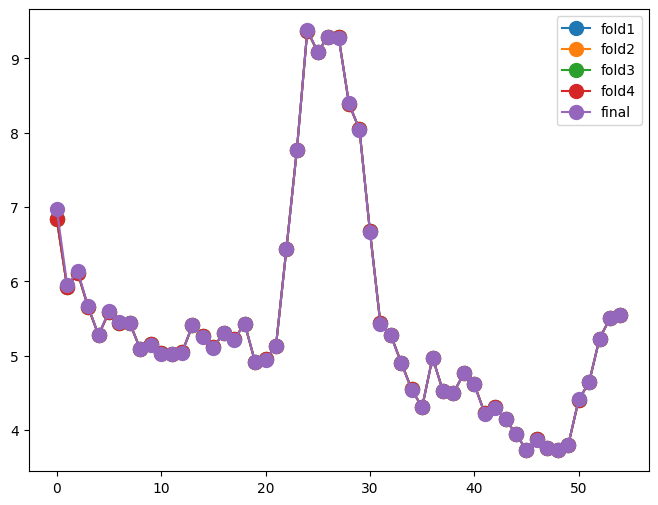

In [26]:
analysis_time = pred_analysis(models_time, y_test)
display_pred_analysis(analysis_time, columns)

# Testing on test set

In [27]:
# all_models = models_date + models_time
all_models = models_time

# **Submission**

In [28]:
def zero_sum(prices, volumes):
    std_error = np.sqrt(volumes)
    step = np.sum(prices) / np.sum(std_error)
    out = prices - std_error * step
    return out

if is_infer:
    import optiver2023
    env = optiver2023.make_env()
    iter_test = env.iter_test()
    counter = 0
    y_min, y_max = -64, 64
    qps, predictions = [], []
    cache = pd.DataFrame()

    # Weights for each fold model
#     if LGB:
#         lgb_model_weights = weighted_average(models)
        #cbt_model_weights = weighted_average(models_cbt)
    
    all_features = list(test_features.columns)
    
    for (test, revealed_targets, sample_prediction) in iter_test:
        now_time = time.time()
        cache = pd.concat([cache, test], ignore_index=True, axis=0)
        if counter > 0:
            cache = cache.groupby(['stock_id']).tail(21).sort_values(by=['date_id', 'seconds_in_bucket', 'stock_id']).reset_index(drop=True)
        feat = generate_all_features(cache)[-len(test):]
        print(f"Feat: {feat.shape}, cache: {cache.shape}")

        # Generate predictions for each model and calculate the weighted average
        if LGB:
            lgb_predictions = np.zeros(len(test))
            for model in (all_models):
                lgb_predictions += model.predict(feat[all_features])
            lgb_predictions = lgb_predictions/len(all_models)

#         predictions = lgb_predictions
        
#         #Using mean predictions rather than zero sum
#         final_predictions = predictions - np.mean(predictions)
        clipped_predictions = np.clip(lgb_predictions, y_min, y_max)
        sample_prediction['target'] = clipped_predictions
        env.predict(sample_prediction)
        counter += 1
        qps.append(time.time() - now_time)
        if counter % 10 == 0:
            print(counter, 'qps:', np.mean(qps))

    time_cost = 1.146 * np.mean(qps)
    print(f"The code will take approximately {np.round(time_cost, 4)} hours to reason about")


This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
Feat: (200, 161), cache: (200, 16)
Feat: (200, 161), cache: (400, 16)
Feat: (200, 161), cache: (600, 16)
Feat: (200, 161), cache: (800, 16)
Feat: (200, 161), cache: (1000, 16)
Feat: (200, 161), cache: (1200, 16)
Feat: (200, 161), cache: (1400, 16)
Feat: (200, 161), cache: (1600, 16)
Feat: (200, 161), cache: (1800, 16)
Feat: (200, 161), cache: (2000, 16)
10 qps: 1.0374698162078857
Feat: (200, 161), cache: (2200, 16)
Feat: (200, 161), cache: (2400, 16)
Feat: (200, 161), cache: (2600, 16)
Feat: (200, 161), cache: (2800, 16)
Feat: (200, 161), cache: (3000, 16)
Feat: (200, 161), cache: (3200, 16)
Feat: (200, 161), cache: (3400, 16)
Feat: (200, 161), cache: (3600, 16)
Feat: (200, 161), cache: (3800, 16)
Feat: (200, 161), cache: (4000, 16)
20 qps: 1.0177861452102661
Feat: (200, 161), cache: (4200, 16)
Feat: (200, 161), cache: (4200, 16)
Feat: (200, 161), cache: (4200, 1